# **dlib.detection으로 고양이 수염 필터 씌우기**
#### 1. 얼굴에 bounding box 그리기  
#### 2. 얼굴 외곽, 눈, 코, 입 landmark 위치 찾기  
#### 3. 고양이 수염 필터 적용 위치 계산  
#### 4. 최종 이미지 출력
#### 5. 전체 과정 함수로 정리

------

> 정면 사진 1장으로는 이미 해봤기 때문에 여러 사진을 불러와서 단계별로 결과를 확인하며 진행  
> 얼굴을 가린 사진, 측면 사진 등이 포함됨 

In [18]:
import os 
import glob
import cv2 
import matplotlib.pyplot as plt 
import numpy as np 
import dlib 
import pandas as pd
import math

In [2]:
# 이미지 불러오기
my_image_path = './files/dlib_face_detection_images/*'
images = glob.glob(my_image_path)

print(images)

['./files/dlib_face_detection_images/IMG_5364.jpeg', './files/dlib_face_detection_images/IMG_5368.jpg', './files/dlib_face_detection_images/IMG_5800.JPG', './files/dlib_face_detection_images/IMG_6432.jpg', './files/dlib_face_detection_images/IMG_6431.JPG', './files/dlib_face_detection_images/IMG_5367.jpg', './files/dlib_face_detection_images/IMG_5366.jpeg', './files/dlib_face_detection_images/IMG_5363.jpg']


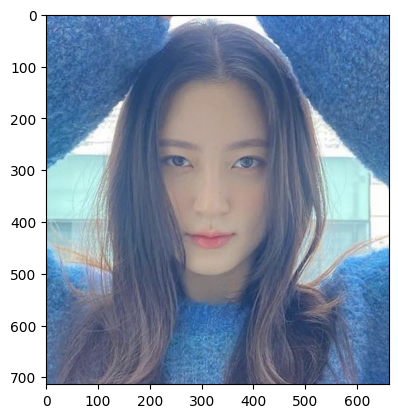

In [3]:
# bgr -> rgb 변환 후 image_list에 저장
image_list = []

for image in images:
    img_bgr = cv2.imread(image)   
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    image_list.append(img_rgb)

plt.imshow(image_list[0])
plt.show()

----

### **1. 얼굴에 bounding box 그리기**  

rectangles[[(200, 231) (468, 498)]]


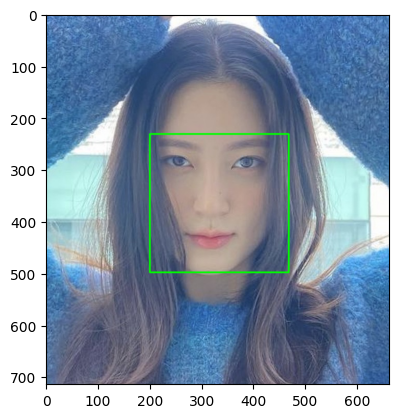

rectangles[[(171, 171) (438, 439)]]


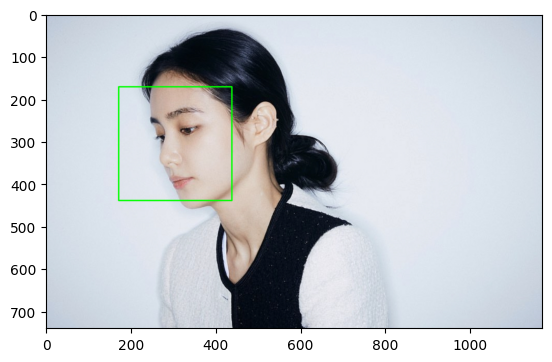

rectangles[[(553, 862) (1016, 1324)]]


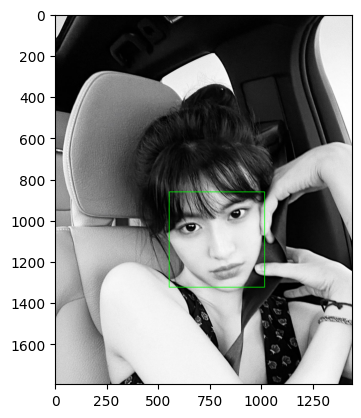

rectangles[[(210, 96) (339, 225)]]


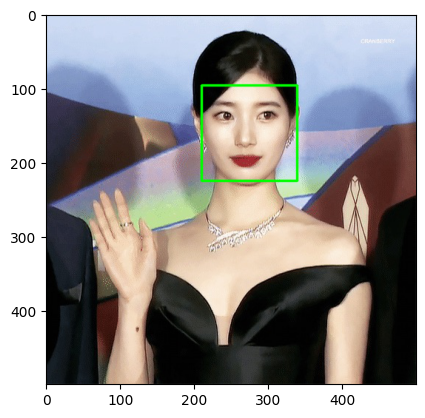

rectangles[[(632, 162) (1017, 547)]]


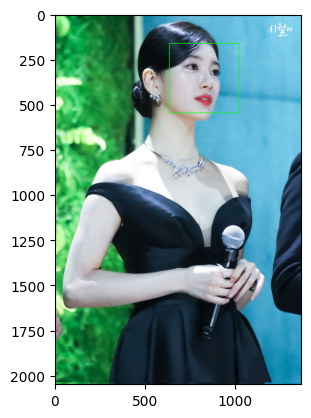

rectangles[[(375, 247) (760, 632)]]


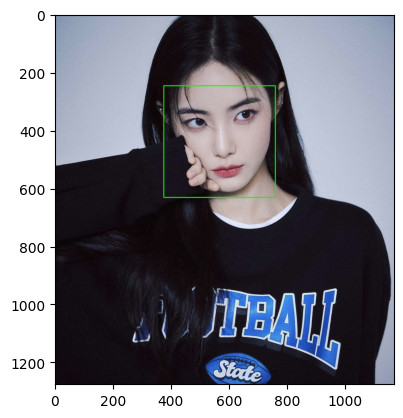

rectangles[[(260, 290) (527, 558)]]


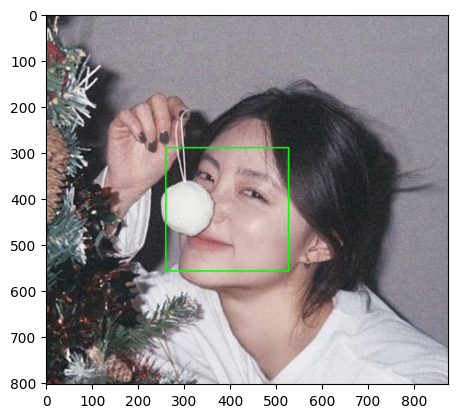

rectangles[[(491, 241) (812, 562)]]


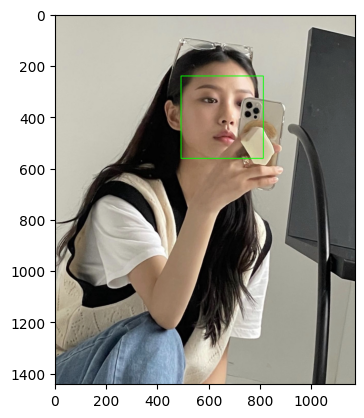

In [4]:
# 얼굴 bounding box 탐지
dlib_rects = [] # 여러 장의 사진들에 대한 얼굴 영역 좌표 저장

for image in image_list:

    detector_hog = dlib.get_frontal_face_detector()
    dlib_rect = detector_hog(image, 1)   # (left, top), (right, bottom)
    dlib_rects.append(dlib_rect)
    print(dlib_rect)
    
    # 찾은 얼굴 영역 좌표
    for rect in dlib_rect: 
        l = rect.left() 
        t = rect.top() 
        r = rect.right() 
        b = rect.bottom() 

        cv2.rectangle(image, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA) # 시작점의 좌표와 종료점 좌표로 직각 사각형을 그림

    plt.imshow(image)
    plt.show()


----

### **2. 얼굴 외곽, 눈, 코, 입 landmark 위치 찾기**

68


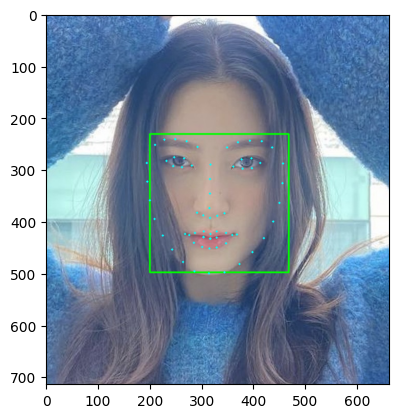

68


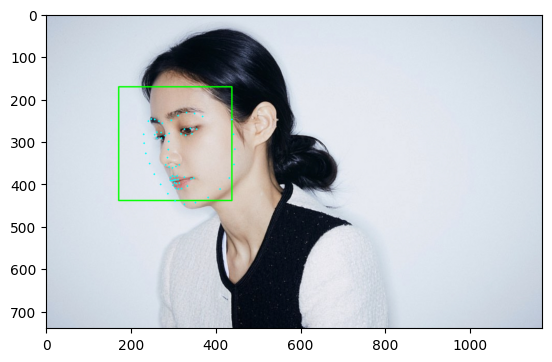

68


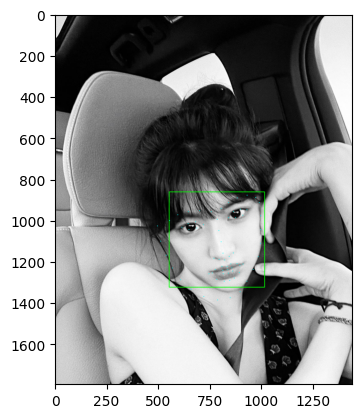

68


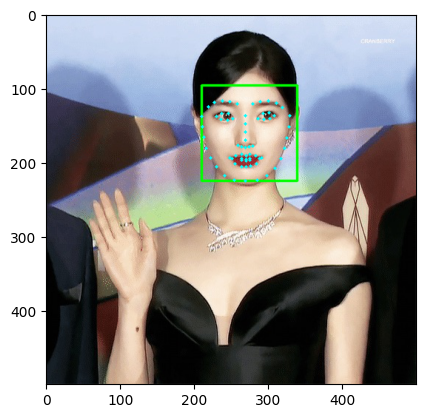

68


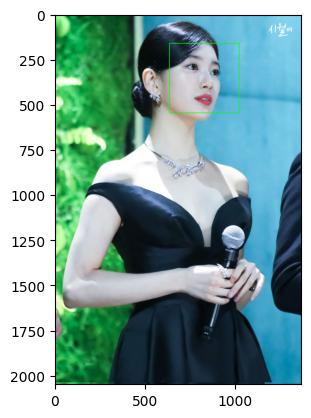

68


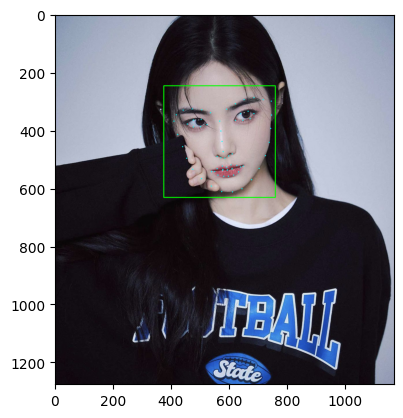

68


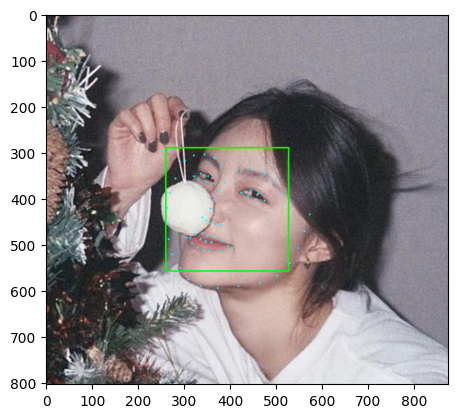

68


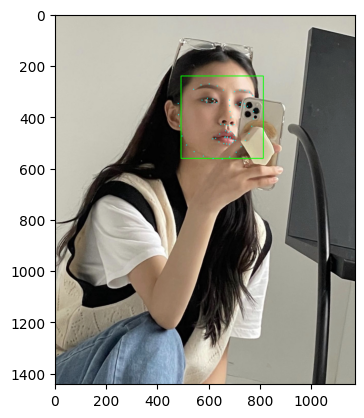

In [5]:
# landmark 탐지로 이목구비 위치 확인
# dlib에서 제공되는 face landmark localization 모델 사용
model_path = '/Users/yena/Desktop/python_study/AIFFEL/EXPLORATION/files/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

list_landmarks = []    # 여러 장의 사진들에 대한 landmark 정보 저장

for i in range(len(image_list)):
    image = image_list[i]
    list_points = []    
       
    for rect in dlib_rects[i]:
        points = landmark_predictor(image, rect)     # 위치정보 저장
        list_points = list(map(lambda p: (p.x, p.y), points.parts()))       # 위치정보 (x,y) 형태로 리스트에 저장
        list_landmarks.append(list_points)
        # 확인
        print(len(list_points))
    
    # landmark 원 그리기
    for point in list_points:
            cv2.circle(image, point, 2, (0, 255, 255), -1)

    plt.imshow(image)
    plt.show()


In [6]:
# 여러 장에 대해 진행해서 오류가 없는지 확실하게 확인하고 진행
df = pd.DataFrame(dlib_rects)
df['list_landmarks'] = list_landmarks
df = df.rename(columns={0:'dlib_rects', 1:'list_landmarks'}) 
df

dlib_rects   
0    [(200, 231) (468, 498)]  \
1    [(171, 171) (438, 439)]   
2  [(553, 862) (1016, 1324)]   
3     [(210, 96) (339, 225)]   
4   [(632, 162) (1017, 547)]   
5    [(375, 247) (760, 632)]   
6    [(260, 290) (527, 558)]   
7    [(491, 241) (812, 562)]   

                                      list_landmarks  
0  [(194, 287), (195, 323), (200, 359), (209, 395...  
1  [(230, 283), (231, 304), (235, 328), (244, 352...  
2  [(496, 1027), (512, 1101), (539, 1169), (569, ...  
3  [(210, 138), (211, 152), (213, 166), (216, 181...  
4  [(578, 319), (580, 372), (583, 424), (598, 474...  
5  [(410, 369), (423, 415), (440, 457), (454, 497...  
6  [(281, 357), (269, 388), (263, 421), (263, 455...  
7  [(480, 348), (481, 392), (485, 436), (495, 475...

----

### **3. 고양이 수염 필터 적용 위치 계산**  

![]()
<img src="/Users/yena/Desktop/python_study/AIFFEL/EXPLORATION/files/dlib.landmark_face.png" width="400px" height="300px" title="px(픽셀) 크기 설정" alt="Markdown Image"></img><br/>

#### **스티커(필터) 위치**  
$y = (eye+mouse)/2$  : 눈과 입의 중간  
$x = nose$  : 코  
$width = height = width(bbox)$  

(315, 374)
0번째 필터 (x,y) : (181,222)
0번째 필터 (w,h) : (269,269)


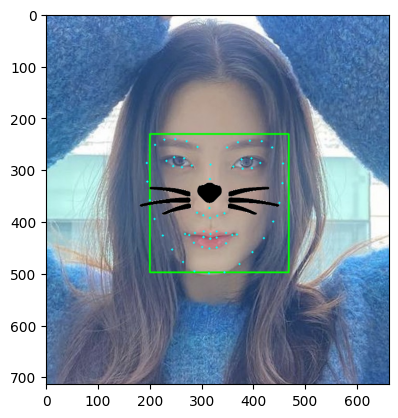

(286, 338)
1번째 필터 (x,y) : (152,202)
1번째 필터 (w,h) : (268,268)


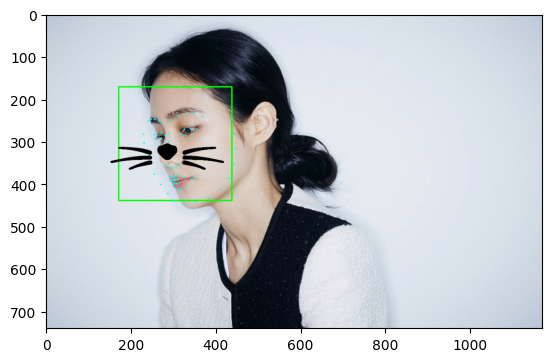

(814, 1159)
2번째 필터 (x,y) : (582,898)
2번째 필터 (w,h) : (464,464)


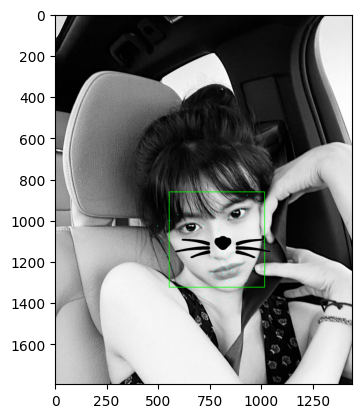

(269, 170)
3번째 필터 (x,y) : (204,101)
3번째 필터 (w,h) : (130,130)


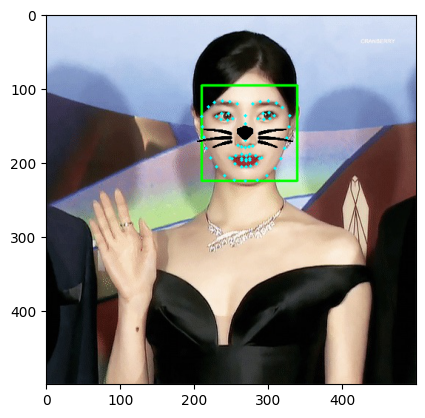

(868, 379)
4번째 필터 (x,y) : (675,181)
4번째 필터 (w,h) : (386,386)


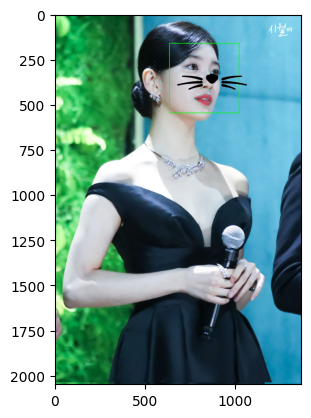

(580, 474)
5번째 필터 (x,y) : (387,263)
5번째 필터 (w,h) : (386,386)


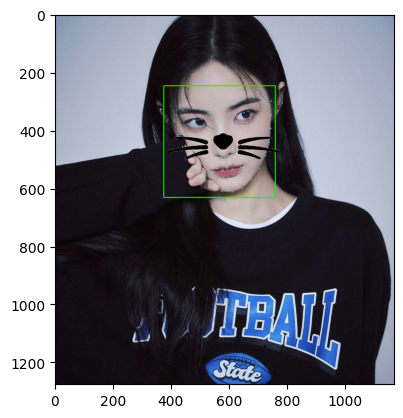

(356, 422)
6번째 필터 (x,y) : (222,285)
6번째 필터 (w,h) : (268,268)


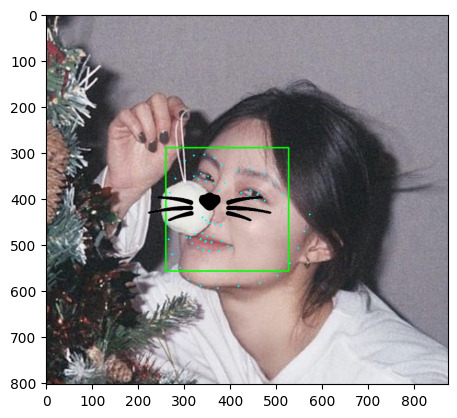

(685, 402)
7번째 필터 (x,y) : (524,239)
7번째 필터 (w,h) : (322,322)


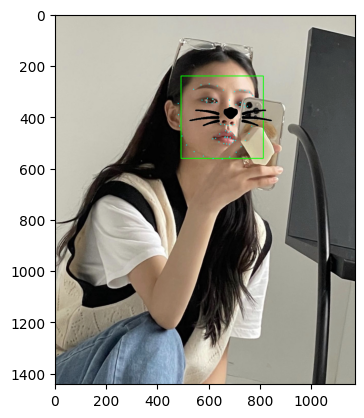

In [7]:
# x, y, witdh, height 계산 후 스티커 조절
sticker_site = []   # 최종 적용 위해 저장

for i in range(len(image_list)):
    # 각 이미지에 대한 정보
    image = image_list[i]
    dlib_rect = dlib_rects[i]
    landmark = list_landmarks[i]
    
    # 새로운 사진마다 스티커 이미지 초기화
    sticker_path = '/Users/yena/Desktop/python_study/AIFFEL/EXPLORATION/files/cat-whiskers.png'
    img_sticker = cv2.imread(sticker_path)    
     
    # 스티커 좌표 설정   
    print(landmark[30])
    w = h = dlib_rect[0].width() 
    x = landmark[30][0] - w//2
    y = ((landmark[40][1] + landmark[50][1])- h)//2 
    # 스티커 좌표 저장
    site = (x, y, w)
    sticker_site.append(site)
    # 스티커 좌표 확인
    print (f'{i}번째 필터 (x,y) : ({x},{y})')  
    print (f'{i}번째 필터 (w,h) : ({w},{h})')  
    # 스티커 사이즈 조정
    img_sticker = cv2.resize(img_sticker, (w,h))
    # 스티커 위치 설정
    sticker_area = image[y:y+img_sticker.shape[0], x:x+img_sticker.shape[1]]
        
    # 스티커 중 검은 수염 부분을 이미지의 해당 위치에 대체
    try : image[y:y+img_sticker.shape[0], x:x+img_sticker.shape[1]] = \
            np.where(img_sticker==255, sticker_area, img_sticker).astype(np.uint8)
    # 필터 적용 불가 시 pass      
    except: 
        pass
    
    plt.imshow(image)
    plt.show()
            


In [8]:
sticker_site

[(181, 222, 269),
 (152, 202, 268),
 (582, 898, 464),
 (204, 101, 130),
 (675, 181, 386),
 (387, 263, 386),
 (222, 285, 268),
 (524, 239, 322)]

----

### **4. 최종 이미지 출력**


['./files/dlib_face_detection_images/IMG_5364.jpeg', './files/dlib_face_detection_images/IMG_5368.jpg', './files/dlib_face_detection_images/IMG_5800.JPG', './files/dlib_face_detection_images/IMG_6432.jpg', './files/dlib_face_detection_images/IMG_6431.JPG', './files/dlib_face_detection_images/IMG_5367.jpg', './files/dlib_face_detection_images/IMG_5366.jpeg', './files/dlib_face_detection_images/IMG_5363.jpg']


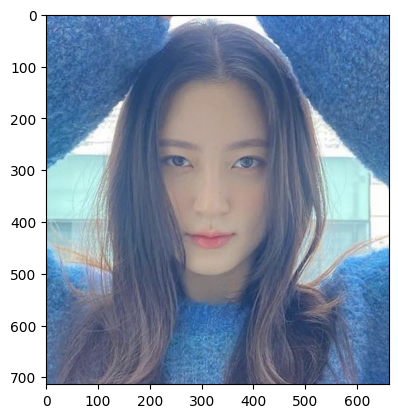

In [9]:
# 이미지 다시 불러오기
my_image_path = './files/dlib_face_detection_images/*'
images = glob.glob(my_image_path)

print(images)

# bgr -> rgb 후 image_org에 저장
image_org = []

for image in images:
    img_bgr = cv2.imread(image)   
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    image_org.append(img_rgb)

plt.imshow(image_org[0])
plt.show()

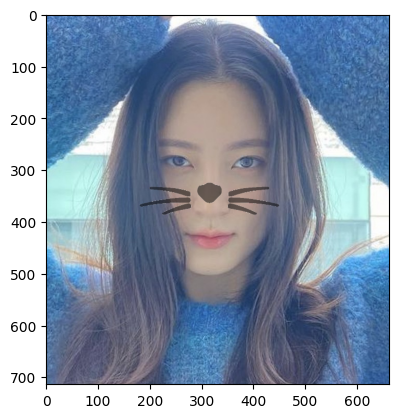

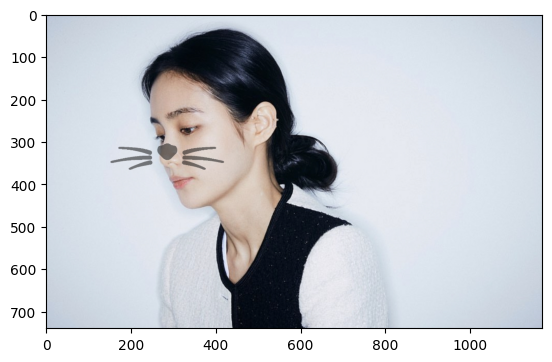

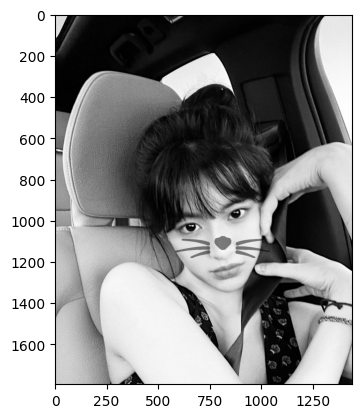

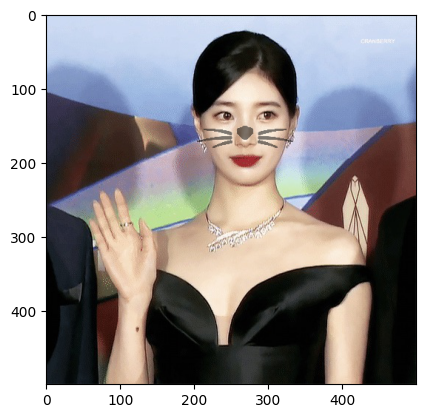

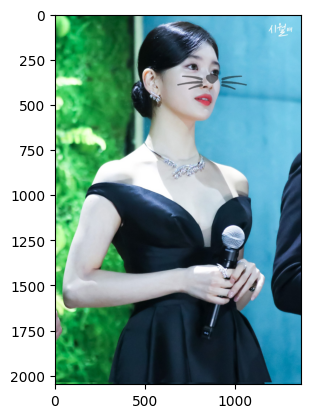

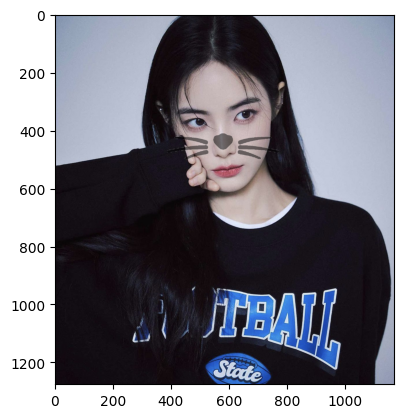

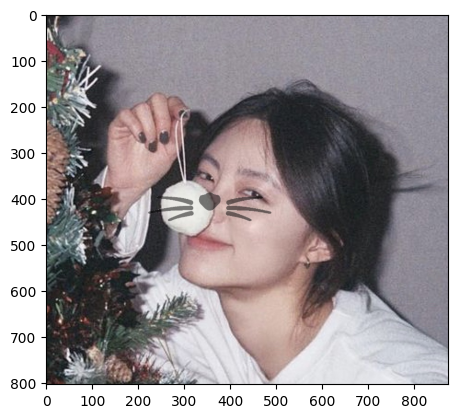

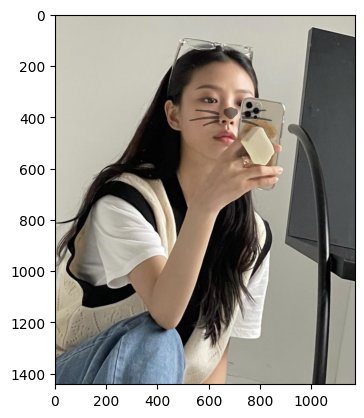

In [10]:
# 필터 적용 최종 결과만 출력
for i in range(len(image_org)):
    new_image = image_org[i]
    
    # 저장해 둔 스티커 위치 정보
    x = sticker_site[i][0]
    y = sticker_site[i][1]
    w = h = sticker_site[i][2]
    
    # 새로운 사진마다 스티커 이미지 초기화 및 크기 설정
    sticker_path = '/Users/yena/Desktop/python_study/AIFFEL/EXPLORATION/files/cat-whiskers.png'
    img_sticker = cv2.imread(sticker_path) 
    img_sticker = cv2.resize(img_sticker, (w,h))
    
    # 스티커 위치 설정
    sticker_area = new_image[y:y +img_sticker.shape[0], x:x+img_sticker.shape[1]]
    # 스티커 중 검은 수염 부분을 이미지의 해당 위치에 대체
    # cv.addWeighted()로 투명도 조절
    new_image[y:y +img_sticker.shape[0], x:x+img_sticker.shape[1]] = \
            cv2.addWeighted(sticker_area,0.5, np.where(img_sticker==255, sticker_area, img_sticker).astype(np.uint8), 0.5, 0)
                        
    plt.imshow(new_image) 
    plt.show()

## **5. 전체 과정 함수로 정리**


In [19]:
# 이미지 불러오기
my_image_path = './files/dlib_face_detection_images/*'
my_images = glob.glob(my_image_path)

print(my_images)

['./files/dlib_face_detection_images/IMG_5364.jpeg', './files/dlib_face_detection_images/IMG_5368.jpg', './files/dlib_face_detection_images/IMG_5800.JPG', './files/dlib_face_detection_images/IMG_6432.jpg', './files/dlib_face_detection_images/IMG_6431.JPG', './files/dlib_face_detection_images/IMG_5367.jpg', './files/dlib_face_detection_images/IMG_5366.jpeg', './files/dlib_face_detection_images/IMG_5363.jpg']


In [20]:
# bgr -> rgb 확인 함수
def bgr2rgb(images):
    global image_list
    image_list=[]
    
    for image in images:
        img_bgr = cv2.imread(image)
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        image_list.append(img_rgb)
    
    # 확인
    print('RGB 변환 확인')
    plt.figure(figsize=(3, 3))    
    plt.imshow(image_list[0])
    plt.show()
    print('RGB 변환 완료')
    print('-'*45)
    
    return image_list
    
# bounding box 찾기  
def bounding_box(image_list):
    global dlib_rects
    dlib_rects=[]
    
    for image in image_list:
        # detector 선언
        detector_hog = dlib.get_frontal_face_detector()
        dlib_rect = detector_hog(image, 1)
        dlib_rects.append(dlib_rect)
        
    return None

# landmark 찾기
def landmark(image_list):
    model_path = '/Users/yena/Desktop/python_study/AIFFEL/EXPLORATION/files/shape_predictor_68_face_landmarks.dat'
    landmark_predictor = dlib.shape_predictor(model_path)
    global list_landmarks
    list_landmarks=[]
    
    for i in range(len(image_list)):
        image = image_list[i]
        list_points=[]
    
        for rect in dlib_rects[i]:
            points = landmark_predictor(image, rect)
            list_points = list(map(lambda p:(p.x, p.y), points.parts()))
            list_landmarks.append(list_points)
            
    return None

# 고양이 수염 sticker 위치 설정 및 최종 이미지 출력/저장
def sticker_save(image_list):
    
    for i in range(len(image_list)):
        image = image_list[i]
        dlib_rect = dlib_rects[i]
        landmark = list_landmarks[i]
        
        sticker_path = '/Users/yena/Desktop/python_study/AIFFEL/EXPLORATION/files/cat-whiskers.png'
        img_sticker = cv2.imread(sticker_path)
        
        # 스티커 좌표 설정   
        w = h = dlib_rect[0].width() 
        x = landmark[30][0] - w//2
        y = ((landmark[40][1] + landmark[50][1])- h)//2 
        # 스티커 회전
        left_eye = landmark[36] 
        right_eye = landmark[45] 
        angle_x = right_eye[0] - left_eye[0]
        angle_y = -(right_eye[1] - left_eye[1])
        
        angle = math.atan2(angle_y,angle_x)
        angle = int(angle * 180 / math.pi)
        
        image_center = tuple(np.array(img_sticker.shape[1::-1])/2)
        rotation = cv2.getRotationMatrix2D(image_center, angle, 1)
        rotated_img = cv2.warpAffine(img_sticker, rotation, img_sticker.shape[1::-1],  borderValue=(255, 255, 255))
        rotated_img = cv2.resize(rotated_img, (w,h))
        image_sticker = rotated_img

        # 스티커 위치 설정
        sticker_area = image[y:y+image_sticker.shape[0], x:x+image_sticker.shape[1]]
        
        # 스티커 중 검은 수염 부분을 이미지의 해당 위치에 대체
        image[y:y+image_sticker.shape[0], x:x+image_sticker.shape[1]] = \
            cv2.addWeighted(sticker_area,0.5, np.where(image_sticker==255, sticker_area, image_sticker).astype(np.uint8), 0.5, 0)

        plt.figure(figsize=(3, 3))    
        plt.imshow(image)
        plt.show()
        
        # 필터 적용 이미지 저장
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        cv2.imwrite('./files/dlib_face_detection_images/result_{}.jpg'.format(i+1), image)
        print('{}번째 사진 변환 및 저장 완료'.format(i+1))
    
    print('='*70)
    print('필터 적용 및 저장 완료')
    
    return None

# 전체 실행
def put_sticker_on(images):
    bgr2rgb(images)
    bounding_box(image_list)
    landmark(image_list)
    sticker_save(image_list)

RGB 변환 확인


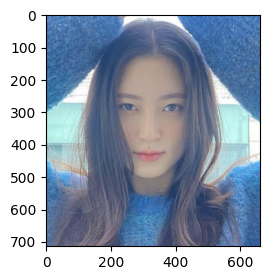

RGB 변환 완료
---------------------------------------------


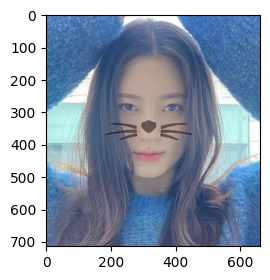

1번째 사진 변환 및 저장 완료


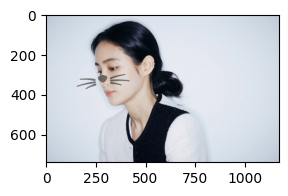

2번째 사진 변환 및 저장 완료


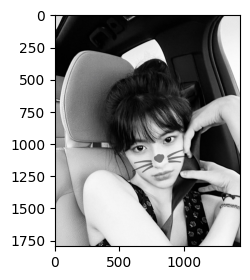

3번째 사진 변환 및 저장 완료


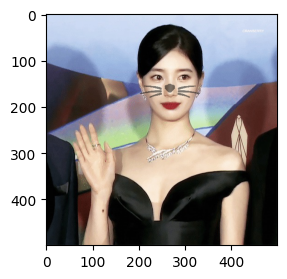

4번째 사진 변환 및 저장 완료


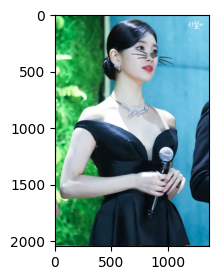

5번째 사진 변환 및 저장 완료


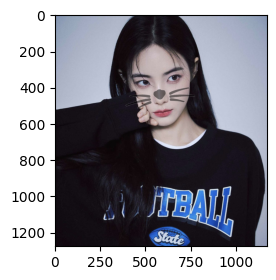

6번째 사진 변환 및 저장 완료


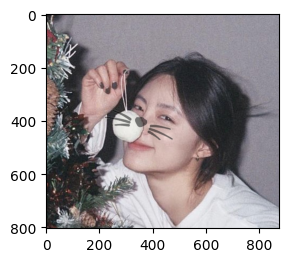

7번째 사진 변환 및 저장 완료


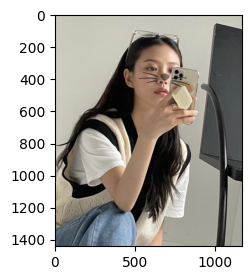

8번째 사진 변환 및 저장 완료
필터 적용 및 저장 완료


In [21]:
put_sticker_on_ = put_sticker_on(my_images)
put_sticker_on_

##### **파일 저장**


![]()
<img src="/Users/yena/Desktop/python_study/AIFFEL/EXPLORATION/files/dlib_face_detection_result_capture.png" width="600px" height="250px" title="px(픽셀) 크기 설정" alt="Markdown Image"></img><br/>

----
## **고찰**  


            


#### **1. landmark 인식 오류**  
  
    - 구글링을 통해 알게 된 사실 : 60도 이상 회전된 사진, 상대적으로 얼굴의 거리가 먼 사진, 과하게 밝은 사진 등에서 landmark 오류 발생  
    - 얼굴인식 필터의 주 사용처를 고려해보았을 때, 셀피에 주로 사용됨(인스타/틱톡 필터 등) -> 60도 이상인 경우가 드물다고 생각됨  
      -> 대부분의 셀피 : 얼굴이 정면을 바라보고, 고개를 살짝 튼 정도 -> 고개의 각도에 맞춰서 필터를 회전 해보기로 결정.  
  


#### **2. 투명도 조절**  
    - cv2.addWeighted()를 사용해서 원본 이미지, 스티커의 alpha, beta 값을 조절 -> 스티커의 투명도를 올려서 얼굴이 비칠 수 있도록 함.  
      


#### **3. 필터 회전**  
    - 수학에서 기본적으로 생각되는 좌표평면과 달리, 이미지 좌표는 왼쪽 위가 (0,0), 오른쪽 아래가 (n,m).  
    - 양쪽 눈을 기준으로 설정  
    - math.atan2()  
    - cv2.getRotationMatrix2D()  
    - cv2.warpAffine()  
    - cv2.getRotationMatrix2D()에서 angle은 시계반대방향이 +.  
    
<img src="/Users/yena/Desktop/python_study/AIFFEL/EXPLORATION/files/face_detection_tan.png" width="500px" height="200px" title="px(픽셀) 크기 설정" alt="Markdown Image"></img><br/>


#### **4. 멀리서 촬영/ 옆으로 누워서 촬영하면 왜 안되는지?**
    - bounding box 혹은 landmark가 얼굴을 제대로 인식하지 못하기 때문    
      


#### **5. 실행 속도의 중요성**  
    - 처음 고려했던 셀피 필터를 생각해보면, 바로바로 적용될 수 있어야 함  
      


#### **6. 정확도가 얼마나 중요할지?**
    - 사진 편집에 대해서는 치명적이지 않지만 detection으로 해야하는 작업이 무엇인지에 따라 매우 다를 것    



              
#### **(+)**
- 얼굴을 가렸을 때 그 부분만 나오지 않게하는 해결 방안이 있을까?